In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/home/brightLLer/anaconda3/envs/speech/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
from keras.preprocessing.image import load_img, img_to_array

In [4]:
target_img_path = 'img/pic1.jpg'
style_ref_img_path = 'img/pic2.jpg'

In [5]:
target_img = load_img(target_img_path)

In [6]:
width, height = target_img.size
print(width, height)

940 627


$$
width :height = new\_width :new\_height
==> new\_width = \frac{width \times new\_height}{height} 
$$

In [7]:
img_height = 300
img_width = int(width * img_height / height)
print(img_width, img_height)

449 300


#### 预处理图片的步骤
+ 根据图片路径，以及设置的目标图片大小预加载图片，使用load_img
+ 将图片装换成numpy数组，使用img_to_array
+ 将图片扩展成四维张量，使用np.expand_dims
+ 依据模型要求进行预处理，比如使用了vgg19，那么就用vgg19.process_input

In [8]:
from keras.applications import vgg19

In [9]:
def process_img(img_path, target_height, target_width):
    img = load_img(img_path, target_size=(target_height, target_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [10]:
def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB',::-1就是逆序的意思(图片的通道维度逆序)
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [11]:
from keras import backend as K

+ 定义好三张图片，其中目标图片和样式参考图片都是静态不变的，用K.constant就可以了
+ 合成的图片是动态改变的，因此，使用K.placeholder

In [12]:
target_image = K.constant(process_img(target_img_path, img_height, img_width))
style_reference_image = K.constant(process_img(style_ref_img_path, img_height, img_width))
combination_img = K.placeholder((1, img_height, img_width, 3))

+ 将三张图片合成一个小的输入批量

In [13]:
input_tensor = K.concatenate([target_image, style_reference_image, combination_img], axis=0)

In [14]:
model = vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)
print('model loaded.')

model loaded.


#### 定义content_loss
+ 图片内容的体现往往反映在高层次的卷积层中

In [15]:
def content_loss(base, combination):
    return K.sum(K.square(base - combination))

#### 定义style_loss
+ style_loss注重于同一卷积层上的特征映射之间的gram矩阵的损失
+ 比如某一层次上的特征映射原本是一个长方体(28, 28, 4),其深度为4，为了计算每个深度切片(28, 28)的正方形，我们需要将长方体切成4个切片，也就是4x(28, 28)的特征映射,表示成张量应该是(4, 28, 28)，在维度转换上，也就是(0, 1, 2)-->(2, 0, 1)，keras的K.permutate可以实现这一点。
+ gram矩阵的计算在两个向量之间更好展开，因此可以使用keras.batch_flatten将第一个维度固定，后面的维度打平，也就是(4, 28, 28)-->(4， 28 * 28),然后使用keras.dot计算gram矩阵

In [16]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram_matrix = K.dot(features, K.transpose(features))
    return gram_matrix

In [17]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

#### 定义total_variation_loss
+ 这种损失用于促进图片在空间上的连续性，可以看成是一种正则化效果
+ 主要关注图片左上角部分与左下角部分，左上角部分与右上角部分的损失，位移为1

In [18]:
def total_variation_loss(x):
    a = K.square(
    x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
    x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [19]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
'block2_conv1',
'block3_conv1',
'block4_conv1',
'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

In [20]:
# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)

#### 将加权的content_loss添加到总损失

In [21]:
layer_features = outputs_dict[content_layer]
# 注意第一个维度batch，回顾input_tensor，第一张图是target,第二张是style,第三张是combination
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features, combination_features)

#### 将加权的style_loss添加到总损失，注意权重由各个style层平分

In [22]:
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl

#### 将加权的total_variant_loss添加到总损失

In [23]:
loss += total_variation_weight * total_variation_loss(combination_img)

#### 使用scipy包的L-BFGS算法进行梯度下降，因为该算法只能对向量进行，因此定义如下的Evaluator方便计算

In [24]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_img)[0]
# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_img], [loss, grads])
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [25]:
evaluator = Evaluator()

In [26]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import os
import time
result_prefix = 'result'
iterations = 20
# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = process_img(target_img_path, img_height, img_width)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    suffix = '0' + str(i) if i < 10 else str(i)
    print(suffix)
    fname = os.path.join('img', result_prefix + '_at_iteration_%s.png' % suffix)
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 1737595000.0
00
Image saved as img/result_at_iteration_00.png
Iteration 0 completed in 4s
Start of iteration 1
Current loss value: 629520800.0
01
Image saved as img/result_at_iteration_01.png
Iteration 1 completed in 2s
Start of iteration 2
Current loss value: 359533600.0
02
Image saved as img/result_at_iteration_02.png
Iteration 2 completed in 3s
Start of iteration 3
Current loss value: 273114270.0
03
Image saved as img/result_at_iteration_03.png
Iteration 3 completed in 2s
Start of iteration 4
Current loss value: 223641580.0
04
Image saved as img/result_at_iteration_04.png
Iteration 4 completed in 3s
Start of iteration 5
Current loss value: 194905150.0
05
Image saved as img/result_at_iteration_05.png
Iteration 5 completed in 2s
Start of iteration 6
Current loss value: 175292540.0
06
Image saved as img/result_at_iteration_06.png
Iteration 6 completed in 3s
Start of iteration 7
Current loss value: 160836060.0
07
Image saved as img/result_at_iter

In [27]:
generate_imgs = [fname for fname in os.listdir('img') if 'png' in fname]
generate_imgs = sorted(generate_imgs)

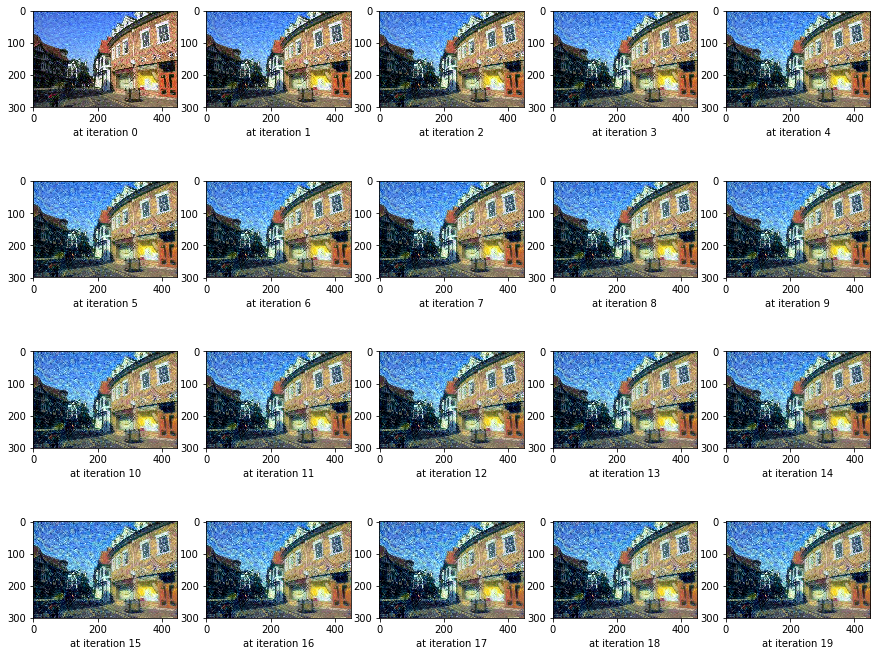

In [28]:
fig, axes = plt.subplots(4, 5)
fig.set_size_inches((15, 12))
for i, (ax, img_path) in enumerate(zip(axes.flatten(), generate_imgs)):
    img = os.path.join('img', img_path)
    ax.imshow(img_to_array(load_img(img)).astype('uint8'))
    ax.set_xlabel('at iteration %d' % i)